# LR training on patch level pooled features

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import class_weight
import numpy as np
np.random.seed(761)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
import random
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression as LR
import matplotlib.pyplot as plt
plt.rcdefaults()
import matplotlib as mpl
mpl.rc("figure", facecolor="white")
from matplotlib import lines
import random
from scipy import interp

In [2]:
def load_labels(path):
    labels = pd.read_csv(path, sep='\t')
    return labels

In [3]:
def get_weights(train):
    # set class weights to deal with the unbalanced nature of the data
    class_weights = class_weight.compute_class_weight('balanced',
                                                      np.unique(train),
                                                      train)

    class_weights = {i: j for i, j in zip(range(2), class_weights)}

    return class_weights

In [40]:
def train_lr_pools(features, labels, do_pca=False, num_pcs=50, splits=10,
                    seed=None, return_list= False, verbose=False):
        
    aucs = []
    for seed_index, split in enumerate(range(splits)):
        # test train split
        X_train, X_test, y_train, y_test = train_test_split(features,
                                                            labels,
                                                            train_size=0.8,
                                                            random_state=seed[seed_index])
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        if do_pca:
            pca = PCA()
            X_train = pca.fit_transform(X_train)
            X_train = X_train[:, :num_pcs]
            X_test = pca.transform(X_test)
            X_test = X_test[:, :num_pcs]
        
        if do_pca:
            # better safe than sorry
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        class_weights = get_weights(y_train)
        clf = LR(penalty='l2', class_weight='balanced', C=0.0001)    
        clf = clf.fit(X_train, y_train)

        # evaluate performance
        probs = clf.predict_proba(X_test)
        auc = roc_auc_score(y_test, probs[:,1])
        if verbose:
            print('Accuracy on Test Data:  {0}'.format(clf.score(X_test, y_test)))
            print('AUC:  {0}\n'.format(auc))
        aucs.append(auc)
             
    return aucs if return_list else sum(aucs)/len(aucs)

In [41]:
def mean_rocs(features, labels, num_pcs=50, splits=10,
                   seed=None, return_list= False, verbose=False):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
        
    tprs = []
    aucs = []
    pcas = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for seed_index, split in enumerate(range(splits)):
        # test train split
        X_train, X_test, y_train, y_test = train_test_split(features,
                                                            labels,
                                                            train_size=0.8,
                                                            random_state=seed[seed_index])
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        pca = PCA()
        X_train = pca.fit_transform(X_train)        
        X_train = X_train[:, :num_pcs]
        X_test = pca.transform(X_test)
        X_test = X_test[:, :num_pcs]
        # save the PCA object
        pcas.append(pca)
        
        # better safe than sorry
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        class_weights = get_weights(y_train)
        clf = LR(penalty='l2', class_weight='balanced', C=0.0001)    
        probs = clf.fit(X_train, y_train).predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
        auc = roc_auc_score(y_test, probs[:,1])
        aucs.append(auc)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
            
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_aucs = round(sum(aucs)/len(aucs), 2)
        
    return (mean_fpr, tprs, mean_aucs, pcas) if return_list else (mean_fpr, mean_tpr, mean_aucs)

# Determine Optimal Number of PCS

In [6]:
# a range of pcs to evaluate
pc_range = np.arange(10, 301, 10)

# we will do 10 splits
random_splits = np.random.choice(1000, 10, replace=False)

## TMB

In [7]:
meta = load_labels('../images.paths.labels.tmb.binary.tsv')
samples = meta['sample'].unique()
label_dict = {i:meta[meta['sample'] == i].iloc[0]['tmb_label'] for i in samples}

# three different types of pooling:  avg, max, and p_norm
avg_features = pd.read_csv('../features/tmb.inceptionv3.avg.pooled.tsv', sep='\t').transpose()
max_features = pd.read_csv('../features/tmb.inceptionv3.max.pooled.tsv', sep='\t').transpose()
pnorm_features = pd.read_csv('../features/tmb.inceptionv3.p_norm.pooled.tsv', sep='\t').transpose()

In [8]:
# avg aucs
auc_avg = []; auc_max = []; auc_pnorm = []
for pcs in pc_range:
    labels = [label_dict[i] for i in avg_features.index.tolist()]
    auc_avg.append(train_lr_pools(avg_features,
                                  labels,
                                  do_pca=True,
                                  num_pcs=pcs,
                                  splits=len(random_splits),
                                  seed=random_splits))
    
    labels = [label_dict[i] for i in max_features.index.tolist()]
    auc_max.append(train_lr_pools(max_features,
                                  labels,
                                  do_pca=True,
                                  num_pcs=pcs, 
                                  splits=len(random_splits), 
                                  seed=random_splits))

    labels = [label_dict[i] for i in pnorm_features.index.tolist()]
    auc_pnorm.append(train_lr_pools(pnorm_features,
                                    labels, do_pca=True,
                                    num_pcs=pcs, 
                                    splits=len(random_splits), 
                                    seed=random_splits))
    

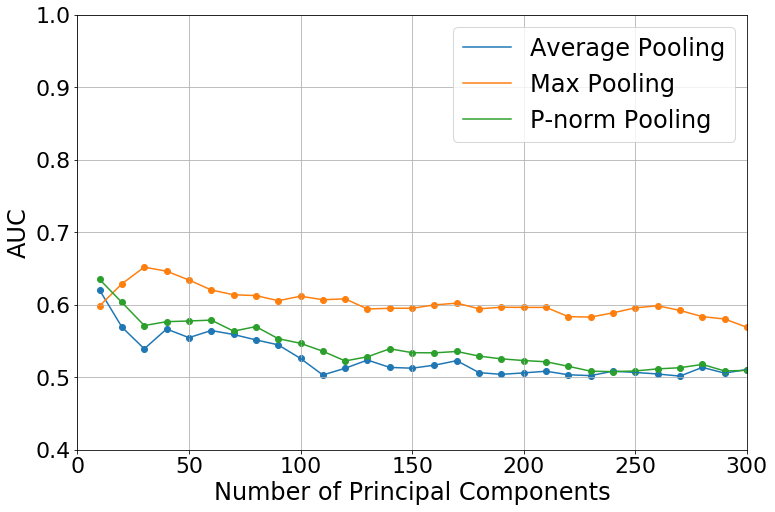

In [9]:
plt.figure(figsize=(12,8))

plt.scatter(pc_range, auc_avg)
plt.plot(pc_range, auc_avg, label='Average Pooling')

plt.scatter(pc_range, auc_max)
plt.plot(pc_range, auc_max, label='Max Pooling')

plt.scatter(pc_range, auc_pnorm)
plt.plot(pc_range, auc_pnorm, label='P-norm Pooling')

plt.xlabel('Number of Principal Components', fontsize=24)
plt.ylabel('AUC', fontsize=24)

plt.xlim([0, max(pc_range)])
plt.xticks(fontsize=22)
plt.ylim([0.4, 1])
plt.yticks(np.arange(0.4,1.001, 0.1), fontsize=22)

plt.legend(fontsize=24)
#plt.title('Average AUC, TMB', fontsize=22)

plt.grid()
plt.show()

## Immune

In [10]:
meta = load_labels('../images.paths.labels.immune.binary.tsv')
samples = meta['sample'].unique()
label_dict = {i:meta[meta['sample'] == i].iloc[0]['immune_sig'] for i in samples}

# three different types of pooling:  avg, max, and p_norm
avg_features = pd.read_csv('../features/immune.inceptionv3.avg.pooled.tsv', sep='\t').transpose()
max_features = pd.read_csv('../features/immune.inceptionv3.max.pooled.tsv', sep='\t').transpose()
pnorm_features = pd.read_csv('../features/immune.inceptionv3.p_norm.pooled.tsv', sep='\t').transpose()

In [11]:
# avg aucs
auc_avg = []; auc_max = []; auc_pnorm = []
for pcs in pc_range:
    labels = [label_dict[i] for i in avg_features.index.tolist()]
    auc_avg.append(train_lr_pools(avg_features,
                                  labels,
                                  do_pca=True, 
                                  num_pcs=pcs, 
                                  splits=10,
                                  seed=random_splits))
    
    labels = [label_dict[i] for i in max_features.index.tolist()]
    auc_max.append(train_lr_pools(max_features,
                                  labels,
                                  do_pca=True,
                                  num_pcs=pcs,
                                  splits=10,
                                  seed=random_splits))
    
    labels = [label_dict[i] for i in pnorm_features.index.tolist()]
    auc_pnorm.append(train_lr_pools(pnorm_features,
                                    labels, 
                                    do_pca=True, 
                                    num_pcs=pcs, 
                                    splits=10, 
                                    seed=random_splits))

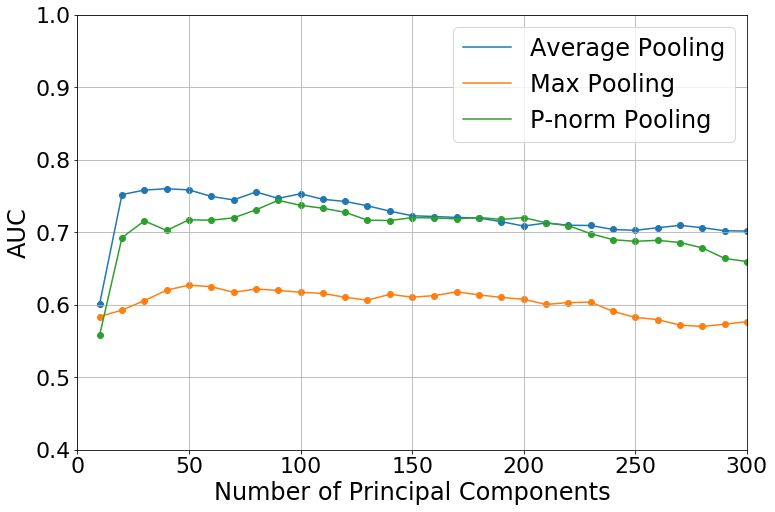

In [12]:
plt.figure(figsize=(12,8))

plt.scatter(pc_range, auc_avg)
plt.plot(pc_range, auc_avg, label='Average Pooling')

plt.scatter(pc_range, auc_max)
plt.plot(pc_range, auc_max, label='Max Pooling')

plt.scatter(pc_range, auc_pnorm)
plt.plot(pc_range, auc_pnorm, label='P-norm Pooling')

plt.xlabel('Number of Principal Components', fontsize=24)
plt.ylabel('AUC', fontsize=24)

plt.xlim([0, max(pc_range)])
plt.xticks(fontsize=22)
plt.ylim([0.4, 1])
plt.yticks(np.arange(0.4,1.001, 0.1), fontsize=22)

plt.legend(fontsize=24)
#plt.title('Average AUC, Immune Signature', fontsize=22)

plt.grid()
plt.show()

# ROC Curves,  boxplots

In [13]:
# 30 PCs is best for both classification tasks
# MAX pooling is best for TMB and average is best for immune signature
best_pcs = 30

meta = load_labels('../images.paths.labels.tmb.binary.tsv')
samples = meta['sample'].unique()
label_dict_tmb = {i:meta[meta['sample'] == i].iloc[0]['tmb_label'] for i in samples}
tmb_avg = pd.read_csv('../features/tmb.inceptionv3.avg.pooled.tsv', sep='\t').transpose()
tmb_max = pd.read_csv('../features/tmb.inceptionv3.max.pooled.tsv', sep='\t').transpose()
tmb_pnorm = pd.read_csv('../features/tmb.inceptionv3.p_norm.pooled.tsv', sep='\t').transpose()

meta = load_labels('../images.paths.labels.immune.binary.tsv')
samples = meta['sample'].unique()
label_dict_immune = {i:meta[meta['sample'] == i].iloc[0]['immune_sig'] for i in samples}
immune_avg = pd.read_csv('../features/immune.inceptionv3.avg.pooled.tsv', sep='\t').transpose()
immune_max = pd.read_csv('../features/immune.inceptionv3.max.pooled.tsv', sep='\t').transpose()
immune_pnorm = pd.read_csv('../features/immune.inceptionv3.p_norm.pooled.tsv', sep='\t').transpose()

In [14]:
# get a boxplot of the AUC across multiple splits
aucs_all = []
for features in [tmb_avg, tmb_max, tmb_pnorm]:
    labels = [label_dict_tmb[i] for i in features.index.tolist()]
    aucs_all.append(train_lr_pools(features,
                              labels,
                              do_pca=True,
                              num_pcs=best_pcs,
                              splits=10,
                              seed=random_splits,
                              return_list=True))

immune_aucs = []
for features in [immune_avg, immune_max, immune_pnorm]:
    labels = [label_dict_immune[i] for i in features.index.tolist()]
    aucs_all.append(train_lr_pools(features,
                              labels,
                              do_pca=True,
                              num_pcs=best_pcs,
                              splits=10,
                              seed=random_splits,
                              return_list=True))

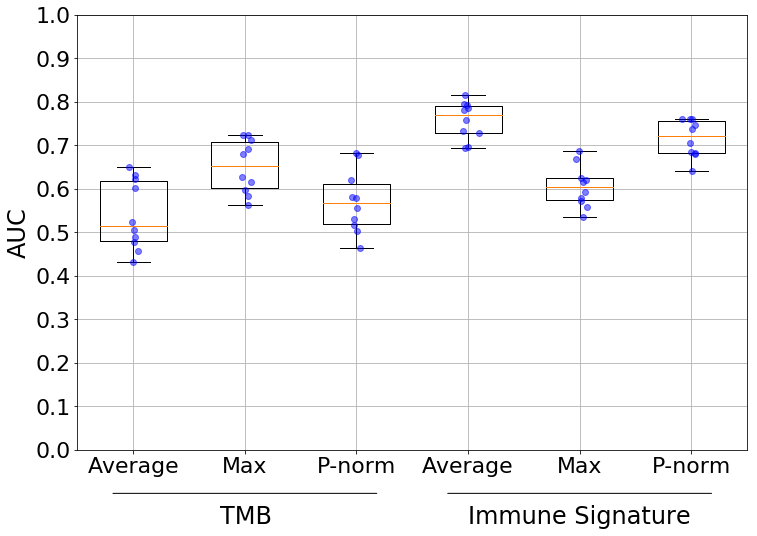

In [15]:
plt.figure(figsize=(12,8))
plt.boxplot(aucs_all, widths=(0.1)*len(aucs_all))

for i in range(len(aucs_all)):
    y = aucs_all[i]
    x = np.random.normal(i+1, 0.03, size=len(y))
    plt.plot(x, y, 'b.', alpha=0.5, markersize=12)

plt.ylim([0,1])
plt.xticks(range(1, 7), ['Average', 'Max', 'P-norm']*2, fontsize=22)
plt.yticks(np.arange(0,1.001, 0.1), fontsize=22)
plt.ylabel('AUC', fontsize=24)
#plt.title('AUC Distribution\n30 PCs, 10 train/test splits', fontsize=22)

plt.annotate('', xy=(0.05, -0.1), xycoords='axes fraction', xytext=(0.45, -0.1), 
            arrowprops=dict(arrowstyle="-", color='black'))

plt.annotate('', xy=(0.55, -0.1), xycoords='axes fraction', xytext=(0.95, -0.1), 
            arrowprops=dict(arrowstyle="-", color='black'))

plt.text(1.78,-.17,'TMB', fontsize=24)
plt.text(4,-.17,'Immune Signature', fontsize=24)

plt.grid()
plt.show()

In [60]:
# now calculate a ROC curve, TMB
labels = [label_dict_tmb[i] for i in tmb_max.index.tolist()]
tmb_fpr_u, tmb_tpr_u, _, pca_tmb = mean_rocs(tmb_max, labels, num_pcs=best_pcs, splits=10, return_list=True, seed=random_splits)
tmb_fpr, tmb_tpr, tmb_aucs = mean_rocs(tmb_max, labels, num_pcs=best_pcs, splits=10, seed=random_splits)

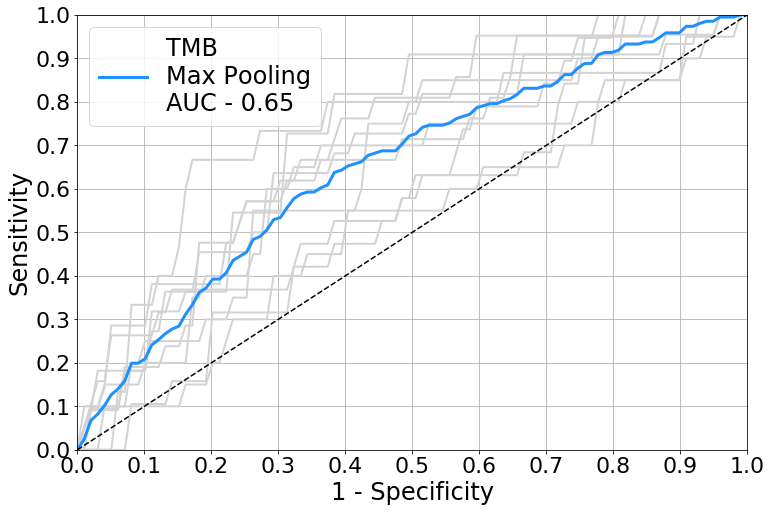

In [61]:
plt.figure(figsize=(12,8))
for split in range(10):
    plt.plot(tmb_fpr_u, tmb_tpr_u[split], color='lightgrey', linewidth=2)
plt.plot(tmb_fpr, tmb_tpr, label='TMB\nMax Pooling\nAUC - {0}'.format(tmb_aucs), color='dodgerblue', linewidth=3)

plt.xticks(np.arange(0,1.001,0.1), fontsize=22)
plt.yticks(np.arange(0,1.001,0.1), fontsize=22)
plt.legend(fontsize=24)
plt.ylabel('Sensitivity', fontsize=24)
plt.xlabel('1 - Specificity', fontsize=24)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0, 1], [0, 1],'k--')
plt.grid()
plt.show()

In [62]:
# now calculate a ROC curve, Immune
labels = [label_dict_immune[i] for i in immune_avg.index.tolist()]
immune_fpr_u, immune_tpr_u, _, pca_immune = mean_rocs(immune_avg, labels, num_pcs=best_pcs, splits=10, return_list=True, seed=random_splits)
immune_fpr, immune_tpr, immune_aucs = mean_rocs(immune_avg, labels, num_pcs=best_pcs, splits=10, seed=random_splits)

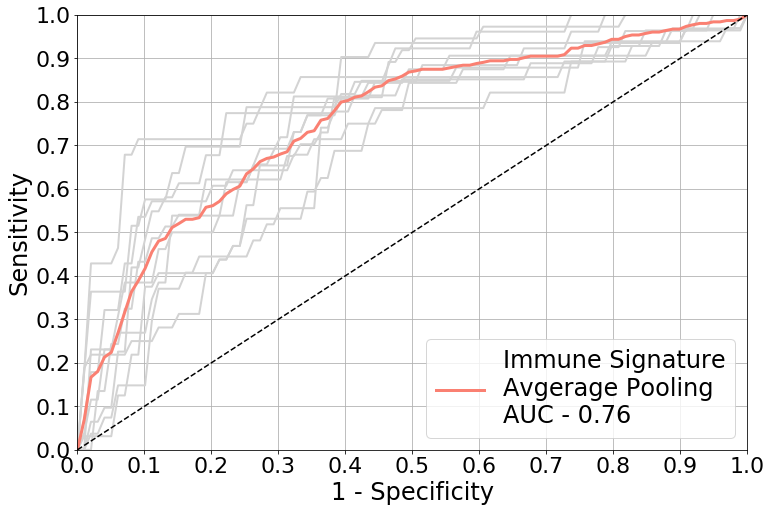

In [63]:
plt.figure(figsize=(12,8))
for split in range(10):
    plt.plot(immune_fpr_u, immune_tpr_u[split], color='lightgrey', linewidth=2)
plt.plot(immune_fpr, immune_tpr, label='Immune Signature\nAvgerage Pooling\nAUC - {0}'.format(immune_aucs), color='salmon', linewidth=3)

plt.xticks(np.arange(0,1.001,0.1), fontsize=22)
plt.yticks(np.arange(0,1.001,0.1), fontsize=22)
plt.legend(fontsize=24)
plt.ylabel('Sensitivity', fontsize=24)
plt.xlabel('1 - Specificity', fontsize=24)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0, 1], [0, 1],'k--')
plt.grid()
plt.show()

TMB, 30PCs variance: 0.56
Immune Signature, 30PCs variance: 0.91


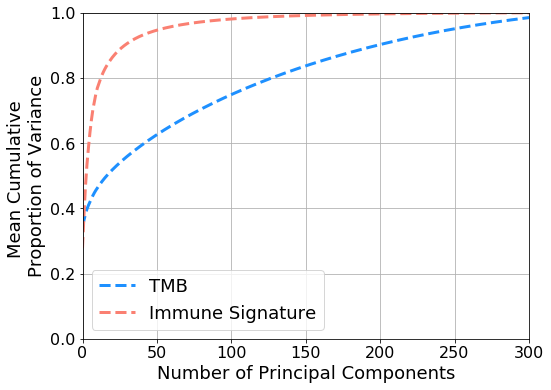

In [86]:
# plot the mean variance explained by each PC across k-folds
cumsums_tmb = []
for pca_ in pca_tmb:
    cumsums_tmb.append(pca_.explained_variance_ratio_.cumsum())
cumsums_tmb = np.array(cumsums_tmb)

print(f'TMB, 30PCs variance: {round(cumsums_tmb.mean(axis=0)[30], 2)}')

cumsums_immune = []
for pca_ in pca_immune:
    cumsums_immune.append(pca_.explained_variance_ratio_.cumsum())
cumsums_immune = np.array(cumsums_immune)

print(f'Immune Signature, 30PCs variance: {round(cumsums_immune.mean(axis=0)[30], 2)}')

plt.figure(figsize=(8,6))
plt.plot(range(cumsums_tmb.shape[1]), cumsums_tmb.mean(axis=0), '--', color='dodgerblue', label='TMB', linewidth=3)
plt.plot(range(cumsums_immune.shape[1]), cumsums_immune.mean(axis=0), '--', color='salmon', label='Immune Signature',linewidth=3)

plt.xticks(fontsize=16)
plt.ylim([0,1])
plt.yticks(fontsize=16)
plt.xlim([0, max(pc_range)])
plt.grid()
plt.xlabel('Number of Principal Components', fontsize=18)
plt.ylabel('Mean Cumulative \nProportion of Variance', fontsize=18)
plt.legend(fontsize=18)
plt.show()